In [65]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
%matplotlib inline

In [205]:
groundTruth = pd.read_csv("data/groundTruth.csv")
class her2Image():
    def __init__(self,caseNumber):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
        self.level = self.nLevels - 3
        self.lowResDims = self.her2.level_dimensions[self.level] #3 is arbitrary but works
        lowRes = np.asarray(self.her2.read_region((0,0),self.level,(self.lowResDims[0],self.lowResDims[1]))) 
        self.lowRes = cv2.cvtColor(lowRes, cv2.COLOR_RGB2GRAY) # Grayscale
        self.lowResArea = reduce(mul,self.lowResDims) # Area of image
        self.mode = mstats.mode(self.lowRes,axis=None)[0]
        
    def show(self):
        plt.imshow(self.lowRes,cm.gray)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        
    def features(self,show=0):
        img = cv2.GaussianBlur(self.lowRes,(47,47),0)
        ret,thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-4,255,1)
        contours,hierarchy = cv2.findContours(thresh, 1, 2)
        self.featureCount = 0
        self.boxes = []
        for cnt in contours:

            #cnt = contours[0]
            M = cv2.moments(cnt)

            rect = cv2.minAreaRect(cnt)
            area = reduce(mul,rect[1])
            if area > self.lowResArea*0.01:
                self.featureCount += 1
                box = cv2.cv.BoxPoints(rect)
                box = np.int0(box)
                self.boxes.append(box)
                cv2.drawContours(self.lowRes,[box],0,(0,255,255),2)
                
        if show == 1: # Display image
            plt.figure(figsize=(10,10))
            plt.imshow(self.lowRes,cmap=cm.gray)
            plt.title("Number of features found = %d" % self.featureCount)
            plt.show()
            
    def upScale(self,level,show=0): 
        self.highResLevel = level
        self.highResSF = np.power(2,self.level-self.highResLevel)
        self.highlevelDims = self.her2.level_dimensions[level]
        self.highRes = np.asarray(self.her2.read_region((0,0),self.highResLevel,(self.highlevelDims[0],self.highlevelDims[1])))
        self.scaledBoxes = [box*self.highResSF for box in self.boxes]
        for box in self.scaledBoxes:
            cv2.drawContours(self.highRes,[box],-1,(0,0,0),100)
        #return scaledBoxes, region
        if show == 1:
            plt.figure(figsize=(10,10))
            plt.imshow(self.highRes)
            plt.show()
            

for i in groundTruth.CaseNo.values[1:2]:
    eg = her2Image(i)
    eg.features(show=0)
    #print(eg.level)
    #print(eg.boxes)
    eg.upScale(4,show=0)

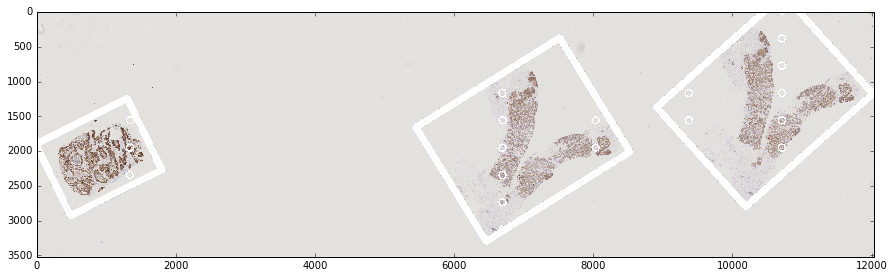

In [206]:
nInterval = 10
coords = [np.linspace(0,dim,nInterval).astype(np.uint32) for dim in eg.highlevelDims]
for i in range(coords[0].shape[0]):
    for j in range(coords[1].shape[0]):
        for box in eg.scaledBoxes:
            test = cv2.pointPolygonTest(box,(coords[0][i],coords[1][j]),False)
            if test == 1:
                cv2.circle(eg.highRes,(coords[0][i], coords[1][j]),50,(255,0,255),thickness=20)
                break
            else:
                #cv2.circle(eg.highRes,(coords[0][i], coords[1][j]),50,(0,0,0),thickness=-2)
                pass
        #print(col)
        
plt.figure(figsize=(15,15))
plt.imshow(eg.highRes)
plt.show()

In [165]:
cv2.pointPolygonTest(eg.scaledBoxes[0],(1000,2500),False)

1.0

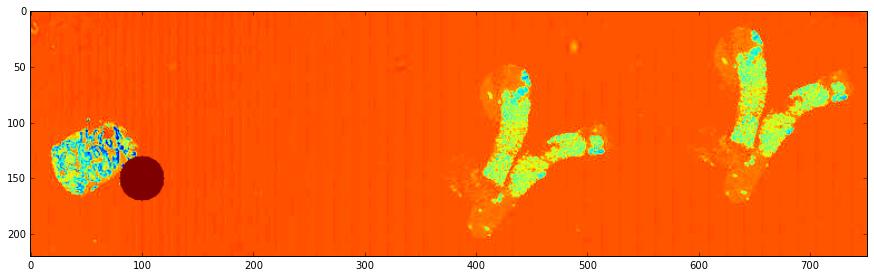

In [186]:
plt.figure(figsize=(15,15))
eg = her2Image(4)
cv2.circle(eg.lowRes,(100, 150),20,(255,0,0),thickness=-1)
plt.imshow(eg.lowRes)
plt.show()

In [134]:
print((coords[0][1], coords[1][1]))

(491, 143)
